In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [2]:
# reload(sdh)

In [3]:
# reload(nn)
import relembed as nn

In [4]:
# reload(eh)
import experiment_helper as eh

In [5]:
shuffle_seed = 20

In [6]:
# reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_150000', valid_percent=1, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
1332856 total examples :: 1319527 training : 13329 valid (99:1 split)
Vocab size: 37292 Dep size: 50 POS size: 18


In [7]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=False, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [8]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

[[268, 240], [495, 34161], [8226, 280], [1306, 621], [659, 4013]]


In [9]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 10


In [10]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token] #/= np.sqrt(np.sum(word2vec[token]**2))#, 1, keepdims=True))
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
# word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

29179 / 37292 pretrained


In [11]:
def reset_drnn(model_name='relembed', bi=True, dep_embed_size=25, pos_embed_size=25, 
               word_embed_size=None, max_grad_norm=3., max_to_keep=10,
               supervised=True, interactive=True):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [12]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,2))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase]
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0,0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [13]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

In [14]:
# reload(dh)
# DH = dh.DataHandler('data/semeval_wiki_sdp_10000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

In [15]:
reload(nn)
drnn = reset_drnn(model_name='wiki_10-7RNNreg', bi=False, word_embed_size=None)

# hyperparameters
num_epochs = 1
batch_size = 50
target_neg=True
neg_per = 15
neg_level = 1
num_nearby = 25
nearby_mod = 150
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

best_valid = 100000
best_model = None

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
                                             neg_per=neg_per, neg_level=neg_level)):
        t0 = time()
        loss = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
#             left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
#             ml,sl = divmod(left, 60)
#             hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec" 
                  % (h,m,s, step, num_steps, epoch, loss, pps))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
#             if valid_loss <= best_valid:
#                 best_valid = valid_loss
#                 best_model = drnn.checkpoint()
        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
unsup_model = drnn.checkpoint()
# print("Best model was %s" % best_model)

<DPNN: W:300, D:25, P:25 H:600, V:37292>
(0:0:9) step 0/26390, epoch 0 Training Loss = 0.80546 :: 876.863 phrases/sec
Top 25 closest phrases to <it> '<X> serves municipalities communities of <Y>' <light>
0: 1.000 : <it> '<X> serves municipalities communities of <Y>' <light>
1: 0.904 : <it> '<X> covers portrays in <Y>' <light>
2: 0.796 : <figure> '<X> of assessment by providing <Y>' <light>
3: 0.746 : <lot> '<X> at begins for <Y>' <light>
4: 0.738 : <it> '<X> of wrote saw <Y>' <it>
5: 0.714 : <light> '<X> like lighthouse was <Y>' <light>
6: 0.710 : <element> '<X> were lamps emitted <Y>' <light>
7: 0.704 : <it> '<X> is part of <Y>' <area>
8: 0.704 : <it> '<X> rumoured house knowledge of <Y>' <egyptians>
9: 0.704 : <light> '<X> <Y>' <light>
10: 0.698 : <it> '<X> said lived days of <Y>' <life>
11: 0.698 : <it> '<X> was policy of secretary of <Y>' <state>
12: 0.693 : <it> '<X> was along edge of <Y>' <technology>
13: 0.691 : <it> '<X> was member of <Y>' <group>
14: 0.685 : <it> '<X> was film

In [16]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [17]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

In [18]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 20
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            model_file = drnn.checkpoint()
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = model_file
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:0) s 0/143, e 0 avg class xent loss = 3.0291
(0:0:1) s 0/143, e 0 validation avg class xent loss = 2.9259
Saving model to file: checkpoints/wiki_10-7RNNreg.ckpt-26390
New best validation
(0:0:13) s 10/143, e 0 avg class xent loss = 2.7468
(0:0:18) s 20/143, e 0 avg class xent loss = 2.8917
(0:0:24) s 30/143, e 0 avg class xent loss = 2.5169
(0:0:30) s 40/143, e 0 avg class xent loss = 2.3861
(0:0:35) s 50/143, e 0 avg class xent loss = 2.2108
(0:0:36) s 50/143, e 0 validation avg class xent loss = 2.3187
Saving model to file: checkpoints/wiki_10-7RNNreg.ckpt-26390
New best validation
(0:0:47) s 60/143, e 0 avg class xent loss = 2.2531
(0:0:51) s 70/143, e 0 avg class xent loss = 2.2280
(0:0:57) s 80/143, e 0 avg class xent loss = 1.9087
(0:1:2) s 90/143, e 0 avg class xent loss = 1.7154
(0:1:7) s 100/143, e 0 avg class xent loss = 2.1833
(0:1:8) s 100/143, e 0 validation avg class xent loss = 1.7690
Saving model to file: checkpoints/wiki_10-7RNNreg.ckpt-26390
New best validation
(

In [ ]:
drnn.checkpoint()

In [ ]:
g = tf.get_default_graph()

In [ ]:
for op in g.get_operations():
    print(op.name)

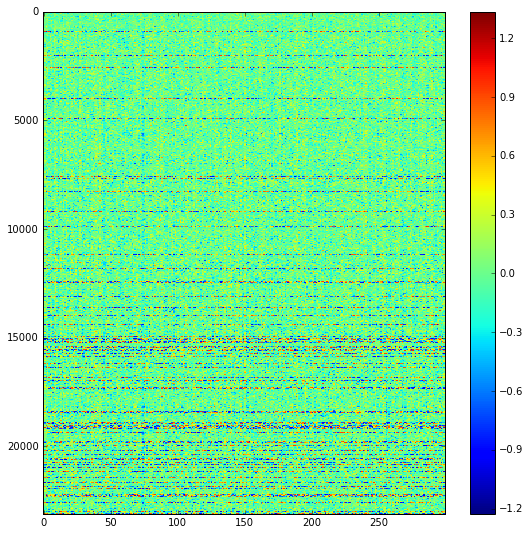

In [24]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(word_embeddings, aspect='auto', interpolation='nearest')
plt.colorbar(im)

/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


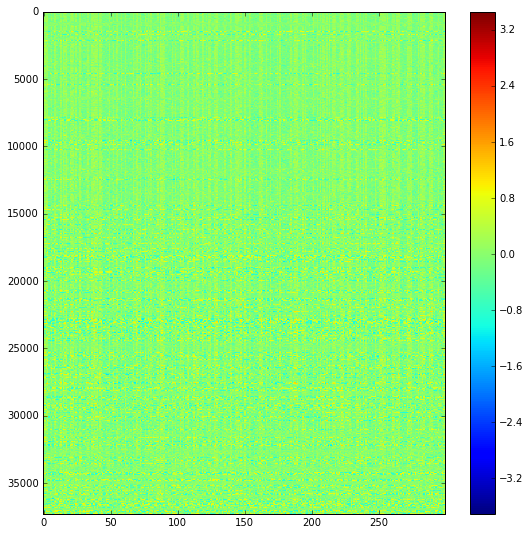

In [19]:
words = drnn._word_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(words, aspect='auto', interpolation='nearest')
plt.colorbar(im)

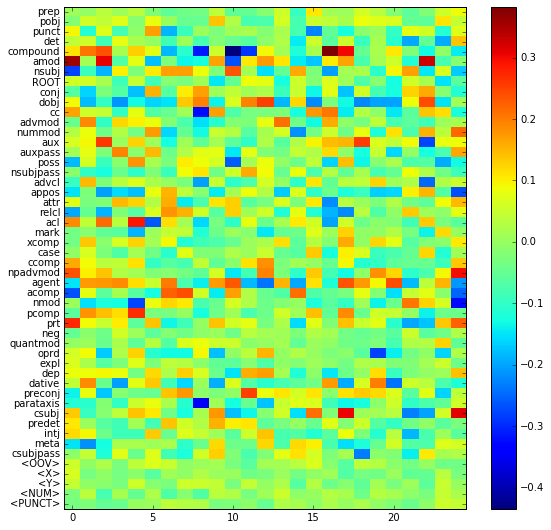

In [20]:
embeds = drnn._dependency_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._dep_vocab)
ax.set_yticks(range(len(DH._dep_vocab)))

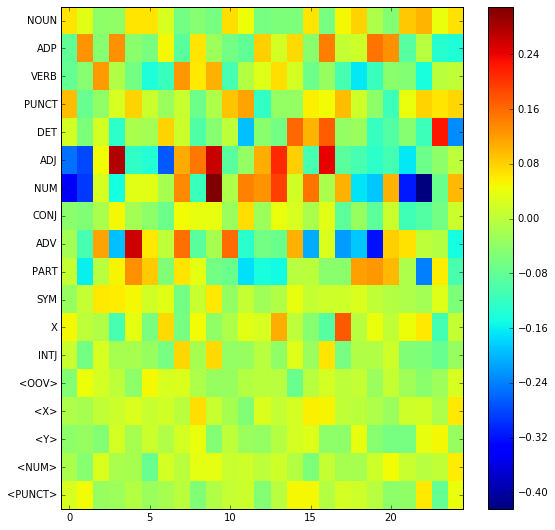

In [21]:
embeds = drnn._pos_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._pos_vocab)
ax.set_yticks(range(len(DH._pos_vocab)))

In [ ]:
# embeds = drnn._left_target_embeddiangs.eval()
# fig, ax = plt.subplots(1,1, figsize=(9,9))
# im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
# plt.colorbar(im)

In [ ]:
# embeds = drnn._right_target_embeddings.eval()
# fig, ax = plt.subplots(1,1, figsize=(9,9))
# im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
# plt.colorbar(im)

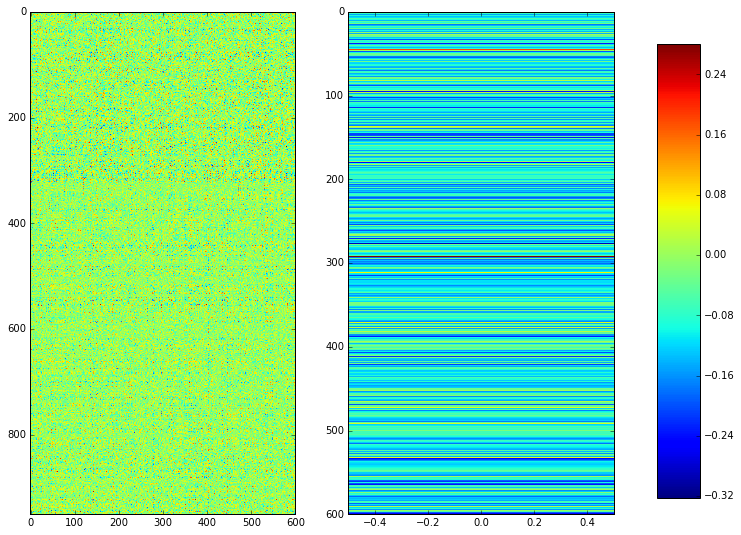

In [22]:
embeds = tf.get_variable('RNN/GRUCell/Candidate/Linear/Matrix').eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = tf.get_variable('RNN/GRUCell/Candidate/Linear/Bias').eval().reshape([-1,1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
### Top half is input, bottom is r*candidate

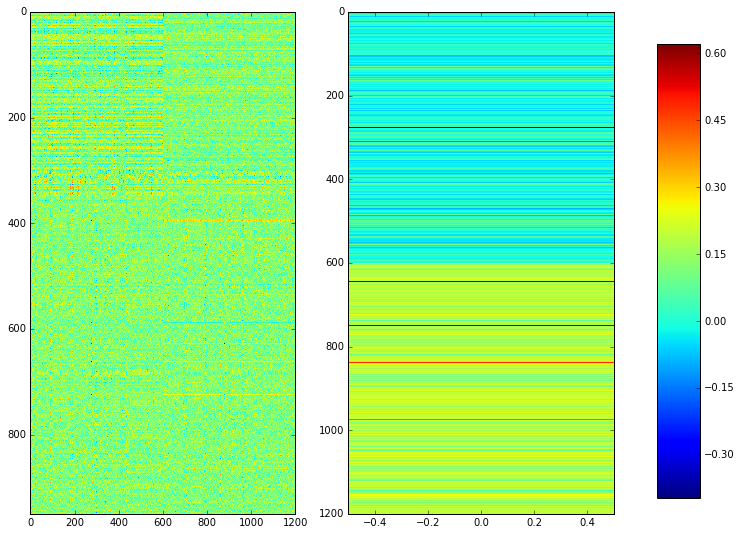

In [23]:
embeds = tf.get_variable('RNN/GRUCell/Gates/Linear/Matrix').eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = tf.get_variable('RNN/GRUCell/Gates/Linear/Bias').eval().reshape([-1,1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# left is r, right is z